In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
from sklearn.pipeline import Pipeline
import pandas as pd
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve, KFold, cross_val_score
import time
import joblib
import optuna
from scipy import stats
import scripts.plotting as pl
import scripts.optimization as opt

## 1. Training data preprocessing

In [3]:
train_df = pd.read_csv('./CSV/train_df.csv')

In [4]:
test_df = pd.read_csv('./CSV/test_df.csv')

In [5]:
genes_of_interest = [
    'RPS7', 'ACTB', 'FTL', 'PPIA', 'TPI1', 'IFRD1', 'HES4', 'LDHA', 'ATP5MF','RPL23A','target'
   ]

In [6]:
train_df_top10 = train_df[genes_of_interest].copy()

In [7]:
test_df_top10 = test_df[genes_of_interest].copy()

In [8]:
X_train = train_df_top10.drop('target', axis=1)
y_train = train_df_top10['target']
feature_names = X_train.columns.tolist()

## 2. Adjusting the weights of the initial 10 genes using Optuna

In [9]:
# ---------------------------------------------------------
# Step 1: Feature Weight Optimization
# ---------------------------------------------------------

# Initial weights
initial_weights_dict = {
    'RPS7': 10.32, 'ACTB': 9.85, 'FTL': 6.30, 
    'PPIA': 4.71, 'TPI1': 4.34, 'IFRD1': 2.20, 
    'HES4': 1.93, 'LDHA': 1.67, 'ATP5MF': 1.44, 'RPL23A': 1.40
}

best_weights_map, study_weights = opt.tune_feature_weights(
    X=X_train, 
    y=y_train, 
    seed = 42,
    feature_names=X_train.columns.tolist(),
    initial_weights=initial_weights_dict,
    n_trials=100
)

print("\nBest Weights Found:")
print(best_weights_map)

[I 2026-02-19 13:27:08,876] A new study created in memory with name: no-name-0133c9e6-69a7-478d-931b-ca196570e2ef


ℹ️ Enqueued initial weights for 10 features.
🚀 Starting Feature Weight Optimization (100 trials)...
✅ Optimization Complete. Best R2: 0.7991

Best Weights Found:
{'RPS7': 5.72824330792637, 'ACTB': 10.931404836806337, 'FTL': 5.578235376257834, 'PPIA': 6.179306682081181, 'TPI1': 6.073276961525867, 'IFRD1': 8.083269982406744, 'HES4': 8.271277993114186, 'LDHA': 4.934727913315634, 'ATP5MF': 5.711139425351098, 'RPL23A': 7.933497432306181}


In [10]:
# ---------------------------------------------------------
# Step 2: Hyperparameter Optimization (with fixed weights)
# ---------------------------------------------------------

best_params, study_params = opt.tune_hyperparameters(
    X=X_train,
    y=y_train,
    seed = 42,
    feature_weights=best_weights_map,
    n_trials=100
)

print("\nBest Hyperparameters:")
print(best_params)

🚀 Starting Hyperparameter Tuning (100 trials)...
✅ Tuning Complete. Best R2: 0.8047

Best Hyperparameters:
{'depth': 8, 'l2_leaf_reg': 3.421777145729413, 'learning_rate': 0.013435839420558617}


## 3. Final model train

In [11]:
#-----------------------------------
# Create and train the tuned model.
#-----------------------------------
print("\nCreate and train the final model with optimal weights and regularization parameters...")

final_weights = [best_weights_map[col] for col in X_train.columns]

print(final_weights)

final_model = CatBoostRegressor(
    iterations=1000,
    random_state=42,
    verbose=0,
    allow_writing_files=False,
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    learning_rate=best_params['learning_rate'],
    feature_weights=final_weights
)

final_model.fit(X_train, y_train)

print("✅ Model training completed.")
print(f"  - Applied Depth: {final_model.get_param('depth')}")
print(f"  - Applied Learning Rate: {final_model.get_param('learning_rate')}")


Create and train the final model with optimal weights and regularization parameters...
[5.72824330792637, 10.931404836806337, 5.578235376257834, 6.179306682081181, 6.073276961525867, 8.083269982406744, 8.271277993114186, 4.934727913315634, 5.711139425351098, 7.933497432306181]
✅ Model training completed.
  - Applied Depth: 8
  - Applied Learning Rate: 0.013435839420558617


In [12]:
joblib.dump(final_model,'./Data/model/Compact_cat_after_tunning.pkl')

['./Data/model/Compact_cat_after_tunning.pkl']

In [9]:
final_model = joblib.load('./Data/model/Compact_cat_after_tunning.pkl')

In [10]:
final_model

## 4. Check model performance and learning curve

In [11]:
target_col = 'target' 

X_test = test_df_top10.drop(columns=[target_col])
y_test = test_df_top10[target_col]

y_pred = final_model.predict(X_test)

In [12]:
# ---------------------------------------------------------
# 1. Model Evaluation Metrics
# ---------------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*30)
print(f"Model Performance (Test Set)")
print("="*30)
print(f"MAE  (Mean Absolute Error)     : {mae:.4f}")
print(f"MSE  (Mean Squared Error)      : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R2 Score (Coefficient of Det.) : {r2:.4f}")
print("="*30)

Model Performance (Test Set)
MAE  (Mean Absolute Error)     : 0.5894
MSE  (Mean Squared Error)      : 0.6454
RMSE (Root Mean Squared Error) : 0.8034
R2 Score (Coefficient of Det.) : 0.7897


In [13]:
actual = y_test.values
predicted = y_pred

In [14]:
pl.set_publication_style()

(<Figure size 1500x1500 with 1 Axes>,
 <Axes: xlabel='Actual value', ylabel='Predicted value'>)

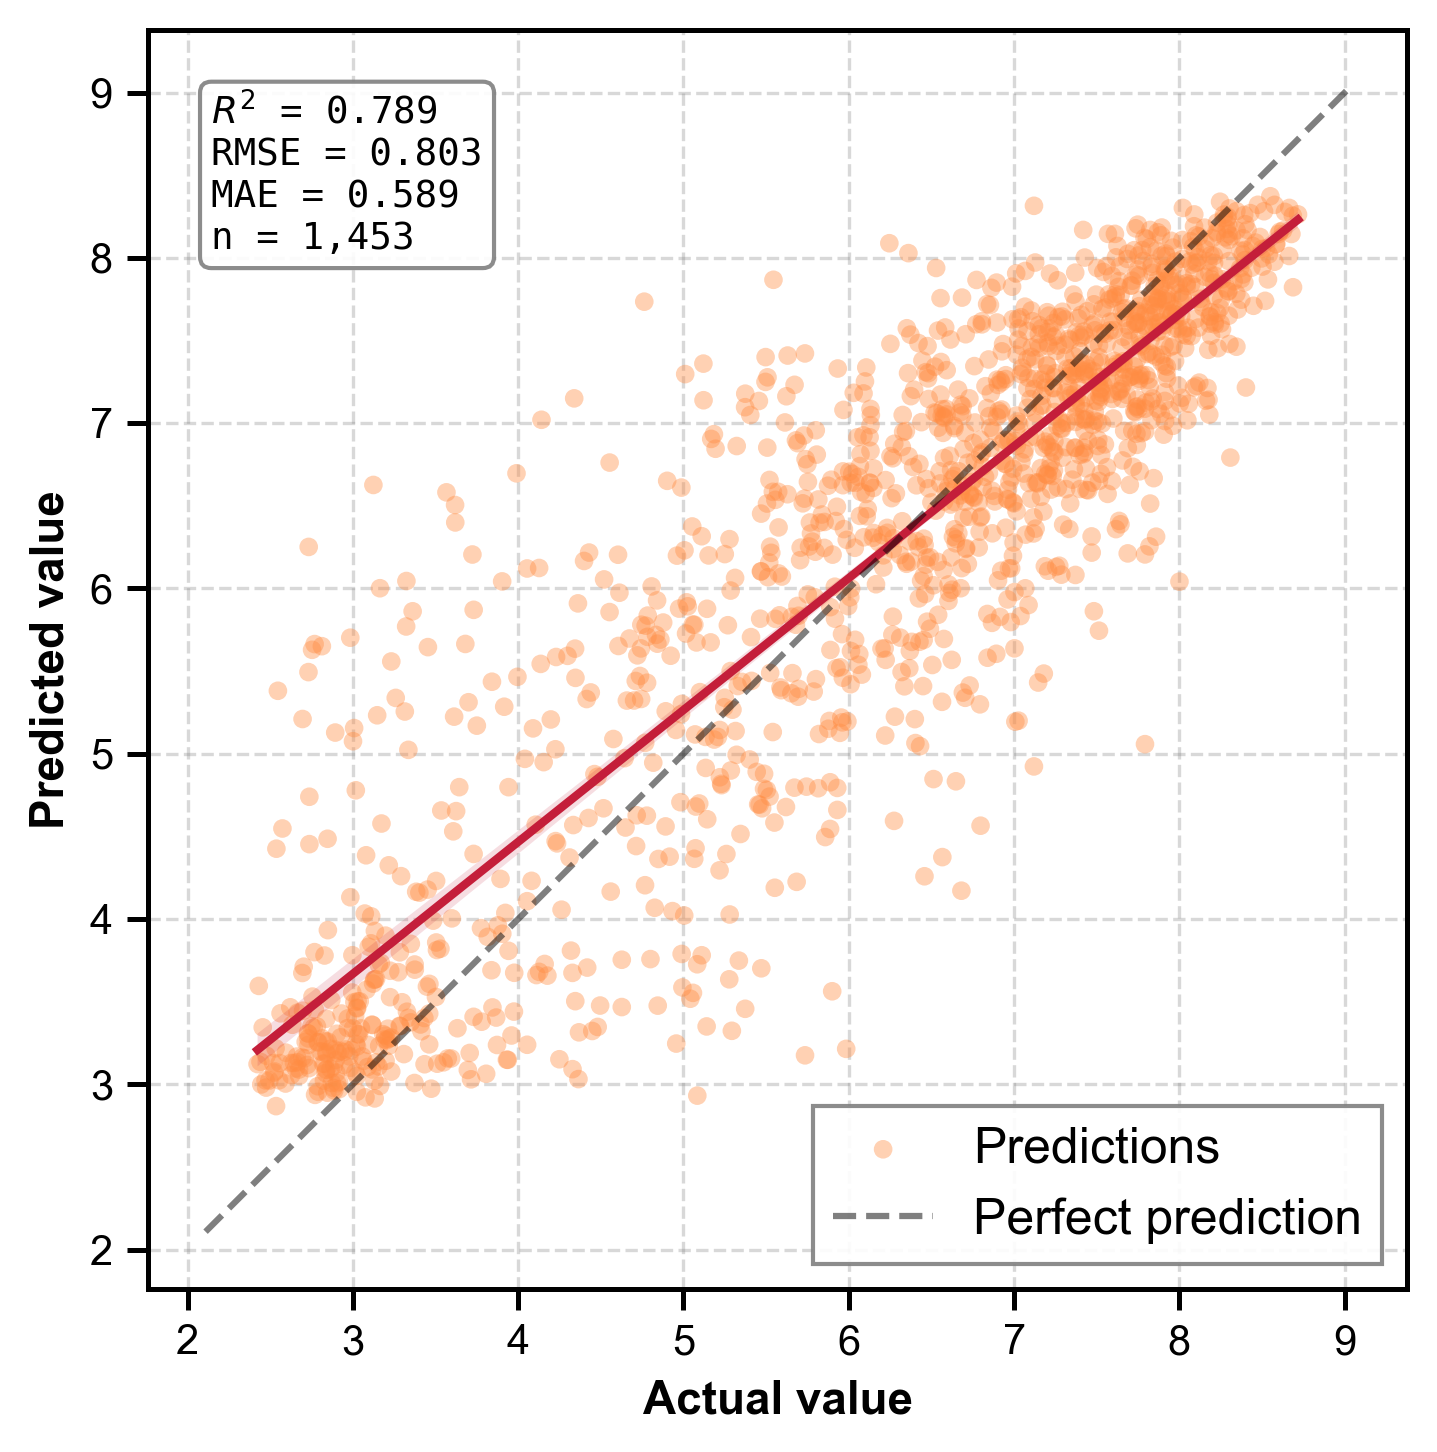

In [15]:
pl.plot_performance_scatter(y_true=actual, y_pred=predicted,save_path='./Plot/Compact_catboost_scatter_performance.png')

Generating learning curve...
Learning curve generated in 50.1s
Final Training R2: 0.8774
Final Validation R2: 0.7006


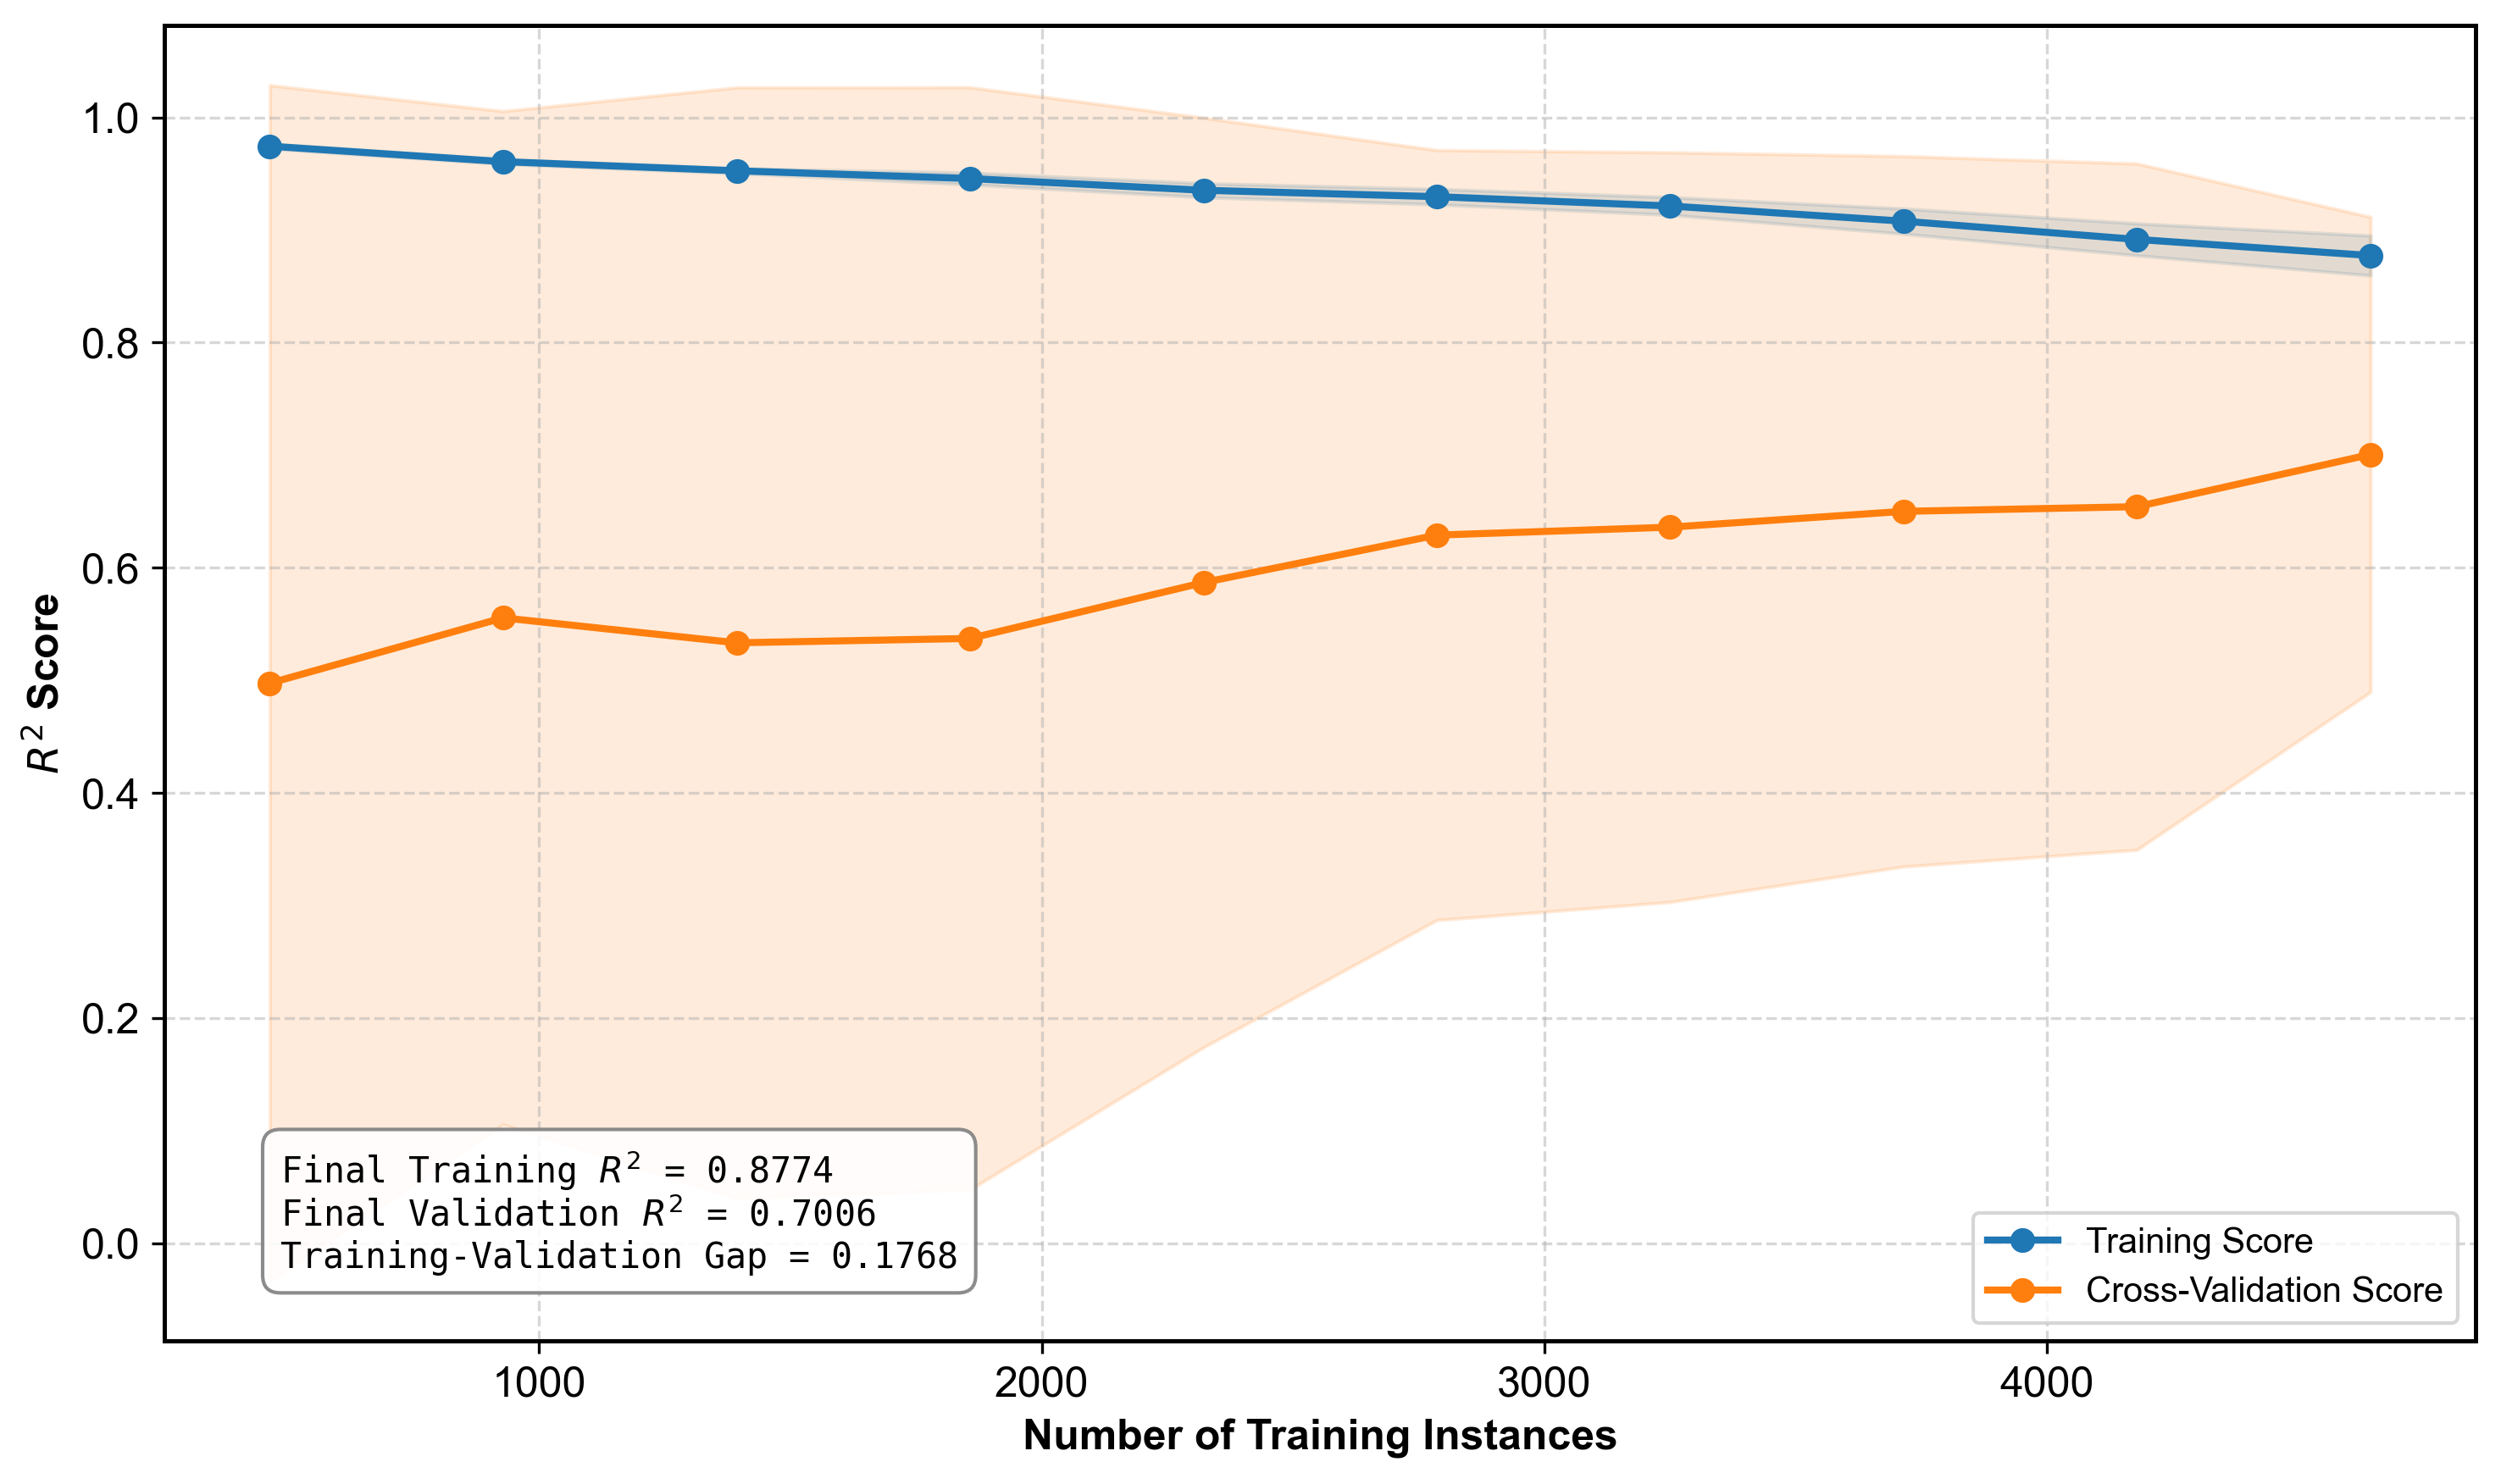

In [20]:
fig, ax = pl.plot_learning_curve(
    model=final_model, 
    X=X_train, 
    y=y_train, 
    cv=5, 
    save_path='./Plot/learning_curve_compact_catboost.png'
)

In [21]:
import session_info

session_info.show()